# Imports and Installs

In [ ]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
import pickle
import sys
import time
import math
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (MinMaxScaler, LabelEncoder, OneHotEncoder,
                                   MultiLabelBinarizer)

import spacy

import tensorflow as tf

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading the Data

In [ ]:
# Path to the files
movies_path = '/content/drive/MyDrive/Datasets/ml-latest-small/movies.csv'
ratings_path = '/content/drive/MyDrive/Datasets/ml-latest-small/ratings.csv'

In [ ]:
# Load each file as a DataFrame
movies_df = pd.read_csv(movies_path)
ratings_df = pd.read_csv(ratings_path)

In [ ]:
# Movies DataFrame
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
# Ratings DataFrame
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


# Merging the Data

In [ ]:
# Merge the movies with ratings
merged_df = pd.merge(ratings_df, movies_df, on='movieId')
merged_df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [ ]:
# Check the shape of the dataset
print(f'There are {merged_df.shape[0]} rows and {merged_df.shape[1]} columns in the merged DataFrame.')

There are 100836 rows and 6 columns in the merged DataFrame.


In [ ]:
# Get quick information about the dataset
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100836 entries, 0 to 100835
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
 4   title      100836 non-null  object 
 5   genres     100836 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 5.4+ MB


# Cleaning the Data

In [ ]:
# Rename columns to be more Pythonic
merged_df.rename(columns={
    'movieId': 'movie_id',
    'userId': 'user_id',
}, inplace=True)

merged_df.head()

,user_id,movie_id,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [ ]:
# Convert timestamp to datetime object
merged_df['timestamp'] = pd.to_datetime(merged_df['timestamp'], unit='s')
merged_df.head()

,user_id,movie_id,rating,timestamp,title,genres
0,1,1,4.0,2000-07-30 18:45:03,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,1996-11-08 06:36:02,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,2005-01-25 06:52:26,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,2017-11-13 12:59:30,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,2011-05-18 05:28:03,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [ ]:
# Extract the year from the 'title' and remove from 'title'
merged_df['year'] = merged_df['title'].str.extract(r'\((\d{4})\)')
merged_df['title'] = merged_df['title'].str.replace(r'\(\d{4}\)', '', regex=True).str.strip()

merged_df.head()

,user_id,movie_id,rating,timestamp,title,genres,year
0,1,1,4.0,2000-07-30 18:45:03,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,5,1,4.0,1996-11-08 06:36:02,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
2,7,1,4.5,2005-01-25 06:52:26,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
3,15,1,2.5,2017-11-13 12:59:30,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
4,17,1,4.5,2011-05-18 05:28:03,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995


In [ ]:
# Count the number of missing release years
missing_release_year = merged_df['year'].isnull().sum()
print(f'There are {missing_release_year} missing release years')

There are 18 missing release years


In [ ]:
# Handle NaN values in 'year'
merged_df['year'] = merged_df['year'].fillna(0)

# Convert 'year' to integers and extract decade
merged_df['year'] = merged_df['year'].astype(int)
merged_df['decade'] = (merged_df['year'] // 10) * 10

merged_df.head()

,user_id,movie_id,rating,timestamp,title,genres,year,decade
0,1,1,4.0,2000-07-30 18:45:03,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,1990
1,5,1,4.0,1996-11-08 06:36:02,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,1990
2,7,1,4.5,2005-01-25 06:52:26,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,1990
3,15,1,2.5,2017-11-13 12:59:30,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,1990
4,17,1,4.5,2011-05-18 05:28:03,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,1990


In [ ]:
# Get count of rows with placeholder release year (zero)
placeholder_release_year = (merged_df['year'] == 0).sum()
print(f'Number of rows with placeholder release years: {placeholder_release_year}')

Number of rows with placeholder release years: 18


In [ ]:
# Remove the rows with placeholder release year (year == 0)
merged_df = merged_df[merged_df['year'] != 0]

# Count again to verify removal
placeholder_release_year_after = (merged_df['year'] == 0).sum()
print(f'Number of rows with placeholder release years after removal: {placeholder_release_year_after}')

Number of rows with placeholder release years after removal: 0


In [ ]:
# Check for missing data
missing_data = merged_df.isnull().sum().sum()
print(f'There are {missing_data} missing values')

There are 0 missing values


In [ ]:
# Save the DataFrame
merged_df.to_csv('/content/drive/My Drive/Datasets/cleaned_movielens_df.csv', index=False)

In [ ]:
# Load the Dataframe
merged_df = pd.read_csv('/content/drive/My Drive/Datasets/cleaned_movielens_df.csv', parse_dates=['timestamp'])

# Preprocessing the Data

## Encoding the Decades

In [ ]:
# One-hot encode the decade
decade_dummies = pd.get_dummies(merged_df['decade'], prefix='decade')
merged_df = pd.concat([merged_df, decade_dummies], axis=1)

# Remove year and decade columns
merged_df.drop(columns={'year', 'decade'}, inplace=True)

## Embeddings for Titles and Genres

In [ ]:
!python -m spacy download en_core_web_md -q

2023-12-17 01:46:53.370175: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-17 01:46:53.370222: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-17 01:46:53.371407: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-17 01:46:54.415301: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 12.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [ ]:
# Load pretrained model
nlp = spacy.load('en_core_web_md')

# Function to generate embeddings
def get_glove_embeddings(text):
  return nlp(text).vector

# Apply the function to titles and genres
tqdm.pandas()

merged_df['title_embed'] = merged_df['title'].progress_apply(get_glove_embeddings)
merged_df['genre_embed'] = merged_df['genres'].progress_apply(get_glove_embeddings)

merged_df.head()

  0%|          | 0/100818 [00:00<?, ?it/s]

  0%|          | 0/100818 [00:00<?, ?it/s]

,user_id,movie_id,rating,timestamp,title,genres,decade_1900,decade_1910,decade_1920,decade_1930,decade_1940,decade_1950,decade_1960,decade_1970,decade_1980,decade_1990,decade_2000,decade_2010,title_embed,genre_embed
0,1,1,4.0,2000-07-30 18:45:03,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,0,0,0,0,0,0,0,0,0,1,0,0,"[-1.115985, -2.1425884, -3.01395, -0.25625002,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,5,1,4.0,1996-11-08 06:36:02,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,0,0,0,0,0,0,0,0,0,1,0,0,"[-1.115985, -2.1425884, -3.01395, -0.25625002,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,7,1,4.5,2005-01-25 06:52:26,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,0,0,0,0,0,0,0,0,0,1,0,0,"[-1.115985, -2.1425884, -3.01395, -0.25625002,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,15,1,2.5,2017-11-13 12:59:30,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,0,0,0,0,0,0,0,0,0,1,0,0,"[-1.115985, -2.1425884, -3.01395, -0.25625002,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,17,1,4.5,2011-05-18 05:28:03,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,0,0,0,0,0,0,0,0,0,1,0,0,"[-1.115985, -2.1425884, -3.01395, -0.25625002,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


## Creating New Indices

In [ ]:
# Create mappings for user_id and movie_id
user_id_mapping = {old: new for new, old in enumerate(merged_df['user_id'].unique())}
movie_id_mapping = {old: new for new, old in enumerate(merged_df['movie_id'].unique())}

# Map the old IDs to new IDs
merged_df['user_id'] = merged_df['user_id'].map(user_id_mapping)
merged_df['movie_id'] = merged_df['movie_id'].map(movie_id_mapping)

In [ ]:
# Create DataFrame copy
merged_df_copy = merged_df.copy()

# Remove title, genres, and year columns
merged_df.drop(columns={'title', 'genres'}, inplace=True)
merged_df.head()

,user_id,movie_id,rating,timestamp,decade_1900,decade_1910,decade_1920,decade_1930,decade_1940,decade_1950,decade_1960,decade_1970,decade_1980,decade_1990,decade_2000,decade_2010,title_embed,genre_embed
0,0,0,4.0,2000-07-30 18:45:03,0,0,0,0,0,0,0,0,0,1,0,0,"[-1.115985, -2.1425884, -3.01395, -0.25625002,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1,0,4.0,1996-11-08 06:36:02,0,0,0,0,0,0,0,0,0,1,0,0,"[-1.115985, -2.1425884, -3.01395, -0.25625002,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2,0,4.5,2005-01-25 06:52:26,0,0,0,0,0,0,0,0,0,1,0,0,"[-1.115985, -2.1425884, -3.01395, -0.25625002,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,3,0,2.5,2017-11-13 12:59:30,0,0,0,0,0,0,0,0,0,1,0,0,"[-1.115985, -2.1425884, -3.01395, -0.25625002,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,4,0,4.5,2011-05-18 05:28:03,0,0,0,0,0,0,0,0,0,1,0,0,"[-1.115985, -2.1425884, -3.01395, -0.25625002,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
# Save the DataFrame
with open('data_with_embeddings.pkl', 'wb') as file:
    pickle.dump(merged_df, file)

In [ ]:
# Save the copy DataFrame
with open('data_with_embeddings_copy.pkl', 'wb') as file:
    pickle.dump(merged_df_copy, file)

In [ ]:
# Load the Dataframe
with open('data_with_embeddings.pkl', 'rb') as file:
    merged_df = pickle.load(file)

## Splitting the Data

In [ ]:
# Remove the timestamp column
merged_df = merged_df.drop(columns=['timestamp'])

In [ ]:
# Split the data into training and temporary sets
train_data, temp_data = train_test_split(merged_df, test_size=0.3, random_state=42)

# Split the temporary set into validation and test sets
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

In [ ]:
# Shape of the splits
print(f'Shape of train data: {train_data.shape}')
print(f'Shape of val data: {val_data.shape}')
print(f'Shape of test data: {test_data.shape}')

Shape of train data: (70572, 17)
Shape of val data: (15123, 17)
Shape of test data: (15123, 17)


## Scaling the Ratings

In [ ]:
# Scale the ratings
scaler = MinMaxScaler(feature_range=(0, 1))

# Normalize the ratings
train_data['rating'] = scaler.fit_transform(train_data[['rating']])
val_data['rating'] = scaler.transform(val_data[['rating']])
test_data['rating'] = scaler.transform(test_data[['rating']])

train_data.head()

,user_id,movie_id,rating,decade_1900,decade_1910,decade_1920,decade_1930,decade_1940,decade_1950,decade_1960,decade_1970,decade_1980,decade_1990,decade_2000,decade_2010,title_embed,genre_embed
19827,132,320,0.555556,0,0,0,0,0,0,0,0,0,1,0,0,"[-7.074925, -2.7924051, 0.65850747, 4.9282002,...","[2.3489, -4.3955, -0.053308, -2.1427, -0.93624..."
9113,74,89,0.777778,0,0,0,0,0,0,0,0,1,0,0,0,"[-2.173451, -1.0286916, -0.31210667, 1.7581973...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
73824,238,2368,0.555556,0,0,0,0,0,0,0,0,0,0,1,0,"[-2.6036, 1.8143, -0.84584, -0.50994, 2.5227, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
21117,65,348,0.777778,0,0,0,0,0,0,0,0,0,1,0,0,"[-3.8022923, -2.07865, 3.2071977, 0.883675, 4....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
90987,83,4988,0.444444,0,0,0,0,0,0,0,0,0,0,1,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


# Datasets & DataLoaders

In [ ]:
# Create PyTorch dataset class
class MovieDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]

        user_id = torch.tensor(row['user_id'])
        movie_id = torch.tensor(row['movie_id'])
        title_embed = torch.tensor(row['title_embed'])
        genre_embed = torch.tensor(row['genre_embed'])
        decade = torch.tensor(row[decade_dummies.columns].values.astype(np.float32))
        rating = torch.tensor(row['rating']).float()

        return user_id, movie_id, title_embed, genre_embed, decade, rating

In [ ]:
# Create the datasets
train_dataset = MovieDataset(train_data)
val_dataset = MovieDataset(val_data)
test_dataset = MovieDataset(test_data)

In [ ]:
# Create the DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    drop_last=True,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    drop_last=True,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    drop_last=True,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

In [ ]:
# Inspect the first batch from the train_loader
first_batch = next(iter(train_loader))
user_id, movie_id, title_embed, genre_embed, decade, rating = first_batch

print(f'User ID: {user_id}')
print(f'Movie ID: {movie_id}')
print(f'Title embeddings: {title_embed}')
print(f'Genre embeddings: {genre_embed}')
print(f'Decade: {decade}')
print(f'Rating: {rating}')

User ID: tensor([270, 440, 201, 310,  26, 246,   0, 196, 254,  32, 162, 548, 158, 229,
        383,  19,  65,  60, 135, 146, 192, 136, 415, 260, 164, 113,  54, 166,
        255, 405, 334, 238])
Movie ID: tensor([ 450, 1434, 1136, 1250,  927, 2199,   38,  170,  735,  481,   22,  895,
         779,  631, 1225, 1631,  866,  399, 2279, 7451,  974,   68,  474,  468,
        1170, 5585, 2900,  116, 3182, 3448,  333,  401])
Title embeddings: tensor([[-2.4306, -0.9364,  0.9306,  ...,  2.4376, -1.0190,  0.6631],
        [-0.4553, -2.3158, -0.5358,  ...,  1.4085,  0.8208,  2.6127],
        [-2.5078, -3.8020,  4.7893,  ..., -2.4499, -0.2514, -2.6198],
        ...,
        [-1.3524, -0.7810, -1.3970,  ...,  4.0329, -4.0257,  1.5227],
        [-5.7054, -4.0166, -0.4800,  ..., -7.7355,  0.1238,  4.0814],
        [-3.2928, -2.2106,  1.1655,  ..., -1.8986, -0.6251,  1.6020]])
Genre embeddings: tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ..

# Building the Model

## LSTM Recommender System

In [ ]:
# LSTM Recommender System
class LSTMRecommender(nn.Module):
    def __init__(self, num_users, num_movies, embedding_dim, hidden_dim, title_emb_dim, genre_emb_dim, decade_emb_dim):
        super(LSTMRecommender, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.movie_embedding = nn.Embedding(num_movies, embedding_dim)

        lstm_input_dim = embedding_dim * 2 + title_emb_dim + genre_emb_dim + decade_emb_dim
        self.lstm = nn.LSTM(input_size=lstm_input_dim, hidden_size=hidden_dim, num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, user_id, movie_id, title_embed, genre_embed, decade):
        user_embed = self.user_embedding(user_id)
        movie_embed = self.movie_embedding(movie_id)

        # Concatenate all embeddings
        combined = torch.cat((user_embed, movie_embed, title_embed, genre_embed, decade), dim=1)

        # Reshape for LSTM
        combined = combined.unsqueeze(1)

        # Process with LSTM
        lstm_output, (hidden, _) = self.lstm(combined)

        # Reshape the output of the last LSTM layer to be [batch_size, hidden_dim]
        hidden = hidden[-1]

        # Pass through the linear layer
        output = self.fc(hidden)

        # Ensure the output is of shape [batch_size, 1]
        output = output.view(-1, 1)

        return output

In [ ]:
class MatrixFactorization(nn.Module):
    def __init__(self, num_users, num_movies, embedding_dim):
        super(MatrixFactorization, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.movie_embedding = nn.Embedding(num_movies, embedding_dim)

    def forward(self, user_ids, movie_ids):
        # Get the embeddings
        user_embeds = self.user_embedding(user_ids)
        movie_embeds = self.movie_embedding(movie_ids)

        # Dot product of user and movie embeddings
        ratings = (user_embeds * movie_embeds).sum(dim=1)

        # Ensure the output is of shape [batch_size, 1]
        ratings = ratings.view(-1, 1)

        return ratings

# Training the Model

In [ ]:
# Set the parameters
num_users = merged_df['user_id'].max() + 1
num_movies = merged_df['movie_id'].max() + 1
embedding_dim = 32
hidden_dim = 64
title_emb_dim = len(merged_df['title_embed'].iloc[0])
genre_emb_dim = len(merged_df['genre_embed'].iloc[0])
decade_emb_dim = len(decade_dummies.columns)

# Initialize the model
model = LSTMRecommender(num_users, num_movies, embedding_dim,
                        hidden_dim, title_emb_dim, genre_emb_dim,
                        decade_emb_dim)

# Use CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
# Set loss function, optimizer, and scheduler
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.1, patience=2, verbose=True
)

# Set number of epochs
num_epochs = 10

In [ ]:
# Function for training step
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0

    train_bar = tqdm(train_loader, desc='Training', total=len(train_loader))
    for user_ids, movie_ids, title_embeds, genre_embeds, decade_embeds, ratings in train_bar:
        # Move to GPU
        user_ids, movie_ids, title_embeds, genre_embeds, decade_embeds, ratings = \
            user_ids.to(device), movie_ids.to(device), title_embeds.to(device), genre_embeds.to(device), decade_embeds.to(device), ratings.to(device)

        # Forward pass
        outputs = model(user_ids, movie_ids, title_embeds, genre_embeds, decade_embeds).view(-1, 1)
        ratings = ratings.view(-1, 1)

        # Calculate loss
        loss = criterion(outputs, ratings)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate and store loss
        total_loss += loss.item()
        mse = loss.item()
        rmse = math.sqrt(mse)

        train_bar.set_postfix({'Loss': loss.item(), 'RMSE': rmse})

    avg_loss = total_loss / len(train_loader)
    avg_rmse = math.sqrt(avg_loss)
    return avg_loss, avg_rmse

In [ ]:
# Function for validation step
def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0

    val_bar = tqdm(val_loader, desc='Validation', total=len(val_loader))
    with torch.no_grad():
        for user_ids, movie_ids, title_embeds, genre_embeds, decade_embeds, ratings in val_bar:
            # Move to GPU
            user_ids, movie_ids, title_embeds, genre_embeds, decade_embeds, ratings = \
                user_ids.to(device), movie_ids.to(device), title_embeds.to(device), genre_embeds.to(device), decade_embeds.to(device), ratings.to(device)

            # Forward pass
            outputs = model(user_ids, movie_ids, title_embeds, genre_embeds, decade_embeds).view(-1, 1)
            ratings = ratings.view(-1, 1)

            # Calculate and store loss
            loss = criterion(outputs, ratings)
            total_loss += loss.item()
            mse = loss.item()
            rmse = math.sqrt(mse)

            val_bar.set_postfix({'Loss': loss.item(), 'RMSE': rmse})

    avg_loss = total_loss / len(val_loader)
    avg_rmse = math.sqrt(avg_loss)
    return avg_loss, avg_rmse

In [ ]:
# Execute the training loop
# Store the losses
train_losses, train_rmse = [], []
val_losses, val_rmse = [], []

# Store the best loss
best_val_loss = float('inf')
best_model_path = 'best_model.pth'

for epoch in range(num_epochs):
    # Train and validate
    avg_train_loss, avg_train_rmse = train_epoch(model, train_loader, criterion, optimizer, device)
    current_val_loss, avg_val_rmse = validate_epoch(model, val_loader, criterion, device)

    train_losses.append(avg_train_loss)
    train_rmse.append(avg_train_rmse)
    val_losses.append(current_val_loss)
    val_rmse.append(avg_val_rmse)

    # Scheduler step
    scheduler.step(current_val_loss)

    # Check if the current validation loss is the best one
    if current_val_loss < best_val_loss:
        best_val_loss = current_val_loss
        # Save the best model
        torch.save(model.state_dict(), best_model_path)
        print(f"Epoch {epoch+1}: Validation loss improved to {current_val_loss:.4f}, saving model to {best_model_path}")
    else:
        print(f"Epoch {epoch+1}: Validation loss did not improve from {best_val_loss:.4f}")

    # Print epoch results including RMSE
    print(f"\n╒═══════════════════════════════════════════════════════════════════╕")
    print(f"│ Epoch {epoch+1}/{num_epochs} - Training Loss: {avg_train_loss:.4f}, RMSE: {avg_train_rmse:.4f} │")
    print(f"│ Validation Loss: {current_val_loss:.4f}, RMSE: {avg_val_rmse:.4f} │")
    print(f"╘═══════════════════════════════════════════════════════════════════╛\n")

Training:   0%|          | 0/2205 [00:00<?, ?it/s]

Validation:   0%|          | 0/472 [00:00<?, ?it/s]

Epoch 1: Validation loss improved to 0.0461, saving model to best_model.pth

╒═══════════════════════════════════════════════════════════════════╕
│ Epoch 1/10 - Training Loss: 0.0519, RMSE: 0.2278 │
│ Validation Loss: 0.0461, RMSE: 0.2146 │
╘═══════════════════════════════════════════════════════════════════╛



Training:   0%|          | 0/2205 [00:00<?, ?it/s]

Validation:   0%|          | 0/472 [00:00<?, ?it/s]

Epoch 2: Validation loss improved to 0.0426, saving model to best_model.pth

╒═══════════════════════════════════════════════════════════════════╕
│ Epoch 2/10 - Training Loss: 0.0426, RMSE: 0.2064 │
│ Validation Loss: 0.0426, RMSE: 0.2065 │
╘═══════════════════════════════════════════════════════════════════╛



Training:   0%|          | 0/2205 [00:00<?, ?it/s]

Validation:   0%|          | 0/472 [00:00<?, ?it/s]

Epoch 3: Validation loss improved to 0.0412, saving model to best_model.pth

╒═══════════════════════════════════════════════════════════════════╕
│ Epoch 3/10 - Training Loss: 0.0397, RMSE: 0.1992 │
│ Validation Loss: 0.0412, RMSE: 0.2029 │
╘═══════════════════════════════════════════════════════════════════╛



Training:   0%|          | 0/2205 [00:00<?, ?it/s]

Validation:   0%|          | 0/472 [00:00<?, ?it/s]

Epoch 4: Validation loss improved to 0.0408, saving model to best_model.pth

╒═══════════════════════════════════════════════════════════════════╕
│ Epoch 4/10 - Training Loss: 0.0379, RMSE: 0.1948 │
│ Validation Loss: 0.0408, RMSE: 0.2021 │
╘═══════════════════════════════════════════════════════════════════╛



Training:   0%|          | 0/2205 [00:00<?, ?it/s]

Validation:   0%|          | 0/472 [00:00<?, ?it/s]

Epoch 5: Validation loss improved to 0.0399, saving model to best_model.pth

╒═══════════════════════════════════════════════════════════════════╕
│ Epoch 5/10 - Training Loss: 0.0368, RMSE: 0.1918 │
│ Validation Loss: 0.0399, RMSE: 0.1997 │
╘═══════════════════════════════════════════════════════════════════╛



Training:   0%|          | 0/2205 [00:00<?, ?it/s]

Validation:   0%|          | 0/472 [00:00<?, ?it/s]

Epoch 6: Validation loss did not improve from 0.0399

╒═══════════════════════════════════════════════════════════════════╕
│ Epoch 6/10 - Training Loss: 0.0356, RMSE: 0.1886 │
│ Validation Loss: 0.0402, RMSE: 0.2005 │
╘═══════════════════════════════════════════════════════════════════╛



Training:   0%|          | 0/2205 [00:00<?, ?it/s]

Validation:   0%|          | 0/472 [00:00<?, ?it/s]

Epoch 7: Validation loss did not improve from 0.0399

╒═══════════════════════════════════════════════════════════════════╕
│ Epoch 7/10 - Training Loss: 0.0345, RMSE: 0.1857 │
│ Validation Loss: 0.0404, RMSE: 0.2010 │
╘═══════════════════════════════════════════════════════════════════╛



Training:   0%|          | 0/2205 [00:00<?, ?it/s]

Validation:   0%|          | 0/472 [00:00<?, ?it/s]

Epoch 8: Validation loss improved to 0.0395, saving model to best_model.pth

╒═══════════════════════════════════════════════════════════════════╕
│ Epoch 8/10 - Training Loss: 0.0337, RMSE: 0.1837 │
│ Validation Loss: 0.0395, RMSE: 0.1987 │
╘═══════════════════════════════════════════════════════════════════╛



Training:   0%|          | 0/2205 [00:00<?, ?it/s]

Validation:   0%|          | 0/472 [00:00<?, ?it/s]

Epoch 9: Validation loss did not improve from 0.0395

╒═══════════════════════════════════════════════════════════════════╕
│ Epoch 9/10 - Training Loss: 0.0330, RMSE: 0.1815 │
│ Validation Loss: 0.0399, RMSE: 0.1999 │
╘═══════════════════════════════════════════════════════════════════╛



Training:   0%|          | 0/2205 [00:00<?, ?it/s]

Validation:   0%|          | 0/472 [00:00<?, ?it/s]

Epoch 10: Validation loss improved to 0.0394, saving model to best_model.pth

╒═══════════════════════════════════════════════════════════════════╕
│ Epoch 10/10 - Training Loss: 0.0324, RMSE: 0.1799 │
│ Validation Loss: 0.0394, RMSE: 0.1985 │
╘═══════════════════════════════════════════════════════════════════╛



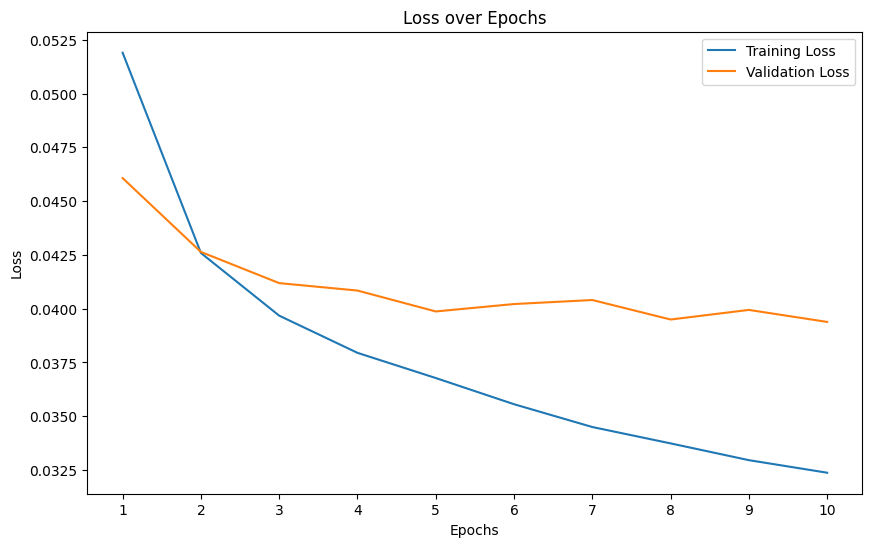

In [ ]:
# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(1, num_epochs + 1))
plt.legend()
plt.show()

In [ ]:
# Load the best model
best_model = LSTMRecommender(num_users, num_movies, embedding_dim,
                             hidden_dim, title_emb_dim, genre_emb_dim,
                             decade_emb_dim)

best_model.load_state_dict(torch.load(best_model_path))
best_model = best_model.to(device)

# Evaluating the Model

In [ ]:
# Function to evaluate on the test set
def evaluate_test_set(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        test_bar = tqdm(test_loader, desc='Testing', total=len(test_loader))
        for user_ids, movie_ids, title_embeds, genre_embeds, decade_embeds, ratings in test_bar:
            # Move to GPU
            user_ids, movie_ids, title_embeds, genre_embeds, decade_embeds, ratings = \
                user_ids.to(device), movie_ids.to(device), title_embeds.to(device), genre_embeds.to(device), decade_embeds.to(device), ratings.to(device)

            # Forward pass
            outputs = model(user_ids, movie_ids, title_embeds, genre_embeds, decade_embeds).view(-1, 1)

            # Ensure the target has the same shape as the output for loss calculation
            ratings = ratings.view(-1, 1)

            # Calculate and store loss
            loss = criterion(outputs, ratings)
            total_loss += loss.item()
            mse = loss.item()
            rmse = math.sqrt(mse)

            # Update tqdm progress bar
            test_bar.set_postfix({'Loss': loss.item(), 'RMSE': rmse})

    avg_loss = total_loss / len(test_loader)
    avg_rmse = math.sqrt(avg_loss)
    return avg_loss, avg_rmse

In [ ]:
# Evaluate on the test set
avg_test_loss, avg_test_rmse = evaluate_test_set(best_model, test_loader, criterion, device)

# Print the test results
print(f"\n╒═══════════════════════════════════════════════════════════════════╕")
print(f"│ Test Set Evaluation - Loss: {avg_test_loss:.4f}, RMSE: {avg_test_rmse:.4f} │")
print(f"╘═══════════════════════════════════════════════════════════════════╛\n")

Testing:   0%|          | 0/472 [00:00<?, ?it/s]


╒═══════════════════════════════════════════════════════════════════╕
│ Test Set Evaluation - Loss: 0.0393, RMSE: 0.1983 │
╘═══════════════════════════════════════════════════════════════════╛



# Making Recommendations

In [ ]:
# Function for making recommendations
def make_recommendations(user_id, model, df, device, top_n=10):
    # Prepare inputs for the model
    movie_ids = df['movie_id'].unique()  # Ensure unique movie IDs
    unique_movies_df = df.drop_duplicates(subset=['movie_id'])  # Unique movies DataFrame

    title_embeddings = np.stack(unique_movies_df['title_embed'])
    genre_embeddings = np.stack(unique_movies_df['genre_embed'])
    decade_embeddings = unique_movies_df[decade_dummies.columns].to_numpy()

    # Convert to PyTorch tensors
    user_ids_tensor = torch.tensor([user_id] * len(movie_ids)).to(device)
    movie_ids_tensor = torch.tensor(movie_ids).to(device)
    title_embeddings_tensor = torch.tensor(title_embeddings).to(device)
    genre_embeddings_tensor = torch.tensor(genre_embeddings).to(device)
    decade_embeddings_tensor = torch.tensor(decade_embeddings).to(device)

    # Predict ratings
    model.eval()
    with torch.no_grad():
        predicted_ratings = model(user_ids_tensor, movie_ids_tensor,
                                  title_embeddings_tensor, genre_embeddings_tensor,
                                  decade_embeddings_tensor).squeeze()

    # Get top N recommendations
    top_indices = predicted_ratings.argsort(descending=True)[:top_n]  # Sort and select top indices
    recommended_movie_ids = movie_ids[top_indices.cpu().numpy()]

    # Fetch movie titles
    recommended_titles = unique_movies_df[unique_movies_df['movie_id'].isin(recommended_movie_ids)]['title'].tolist()

    return recommended_titles

In [ ]:
# Get recommendations
user_id_for_recommendation = 1
top_recommendations = make_recommendations(user_id_for_recommendation, model, merged_df_copy, device, top_n=10)

# Print recommended movie titles
print(f"Top 10 Recommendations for User ID: {user_id_for_recommendation}")
for idx, title in enumerate(top_recommendations, start=1):
    print(f"{idx}. {title}")

Top 10 Recommendations for User ID: 1
1. North by Northwest
2. When We Were Kings
3. 00 Schneider - Jagd auf Nihil Baxter
4. Monsieur Lazhar
5. Paths of Glory
6. Cheburashka
7. Mean Streets
8. Scoop
9. I Am Not Your Negro
10. Man Escaped, A (Un  condamné à mort s'est échappé ou Le vent souffle où il veut)


In [ ]:
# Function to rescale the ratings
def rescale_ratings(predicted_ratings, min_rating, max_rating):
    # Rescale the predicted ratings
    rescaled_ratings = predicted_ratings * (max_rating - min_rating) + min_rating

    # Clip the rescaled ratings to ensure they are within the original rating scale
    rescaled_ratings = torch.clamp(rescaled_ratings, min_rating, max_rating)
    return rescaled_ratings

# Function for making recommendations
def make_recommendations_with_ratings(user_id, model, df, device, top_n=10, min_rating=1, max_rating=5):
    # Prepare inputs for the model
    movie_ids = df['movie_id'].unique()
    unique_movies_df = df.drop_duplicates(subset=['movie_id'])

    title_embeddings = np.stack(unique_movies_df['title_embed'])
    genre_embeddings = np.stack(unique_movies_df['genre_embed'])
    decade_embeddings = unique_movies_df[decade_dummies.columns].to_numpy()

    # Convert to PyTorch tensors
    user_ids_tensor = torch.tensor([user_id] * len(movie_ids)).to(device)
    movie_ids_tensor = torch.tensor(movie_ids).to(device)
    title_embeddings_tensor = torch.tensor(title_embeddings).to(device)
    genre_embeddings_tensor = torch.tensor(genre_embeddings).to(device)
    decade_embeddings_tensor = torch.tensor(decade_embeddings).to(device)

    # Predict ratings
    model.eval()
    with torch.no_grad():
        predicted_ratings = model(user_ids_tensor, movie_ids_tensor,
                                  title_embeddings_tensor, genre_embeddings_tensor,
                                  decade_embeddings_tensor).squeeze()

    # Rescale ratings to original scale
    rescaled_ratings = rescale_ratings(predicted_ratings, min_rating, max_rating)

    # Get top N recommendations
    top_indices = rescaled_ratings.argsort(descending=True)[:top_n]
    top_ratings = rescaled_ratings[top_indices]
    recommended_movie_ids = movie_ids[top_indices.cpu().numpy()]

    # Fetch movie titles and predicted ratings
    recommended_titles_ratings = [(unique_movies_df.loc[unique_movies_df['movie_id'] == movie_id, 'title'].values[0],
                                   rating.item())
                                  for movie_id, rating in zip(recommended_movie_ids, top_ratings)]

    return recommended_titles_ratings

In [ ]:
# Get recommendations with predicted ratings
user_id_for_recommendation = 1
recommendations_with_ratings = make_recommendations_with_ratings(user_id_for_recommendation, model, merged_df_copy, device, top_n=10, min_rating=1, max_rating=5)

# Print recommended movie titles with predicted ratings
print(f"Top 10 Recommendations for User ID {user_id_for_recommendation} with Predicted Ratings:")
for idx, (title, rating) in enumerate(recommendations_with_ratings, start=1):
    print(f"{idx}. {title} - Predicted Rating: {rating:.2f}")

Top 10 Recommendations for User ID 1 with Predicted Ratings:
1. Cheburashka - Predicted Rating: 5.00
2. Scoop - Predicted Rating: 5.00
3. Man Escaped, A (Un  condamné à mort s'est échappé ou Le vent souffle où il veut) - Predicted Rating: 4.92
4. Mean Streets - Predicted Rating: 4.89
5. When We Were Kings - Predicted Rating: 4.89
6. I Am Not Your Negro - Predicted Rating: 4.88
7. Monsieur Lazhar - Predicted Rating: 4.88
8. North by Northwest - Predicted Rating: 4.87
9. Paths of Glory - Predicted Rating: 4.86
10. 00 Schneider - Jagd auf Nihil Baxter - Predicted Rating: 4.83


In [ ]:
# Function to view user rating history
def user_rating_history(user_id, df):
    # Filter the dataframe for the given user ID
    user_ratings = df[df['user_id'] == user_id]

    # Sort by rating in descending order
    user_ratings_sorted = user_ratings.sort_values(by='rating', ascending=False)

    # Select relevant columns to display
    history = user_ratings_sorted[['movie_id', 'title', 'rating']]

    return history

In [ ]:
# Display rating history for user
user_id_for_history = 1
user_history = user_rating_history(user_id_for_history, merged_df_copy)
print(f"Rating History for User ID: {user_id_for_history}")
print(user_history)

Rating History for User ID: 1
       movie_id                                              title  rating
20123       323                               Beauty and the Beast     5.0
25892       468                                 Once Were Warriors     5.0
19183       295                         Postman, The (Postino, Il)     5.0
4590         35                                          Pinocchio     5.0
3958         32                                 Dances with Wolves     5.0
19335       306                                 Heavenly Creatures     5.0
3572         28                                   Schindler's List     5.0
1821         16                                       Pulp Fiction     5.0
26938       479                    Snow White and the Seven Dwarfs     5.0
19722       317                          In the Name of the Father     5.0
25782       466                                       Little Women     4.0
26582       474                                In the Line of Fire    

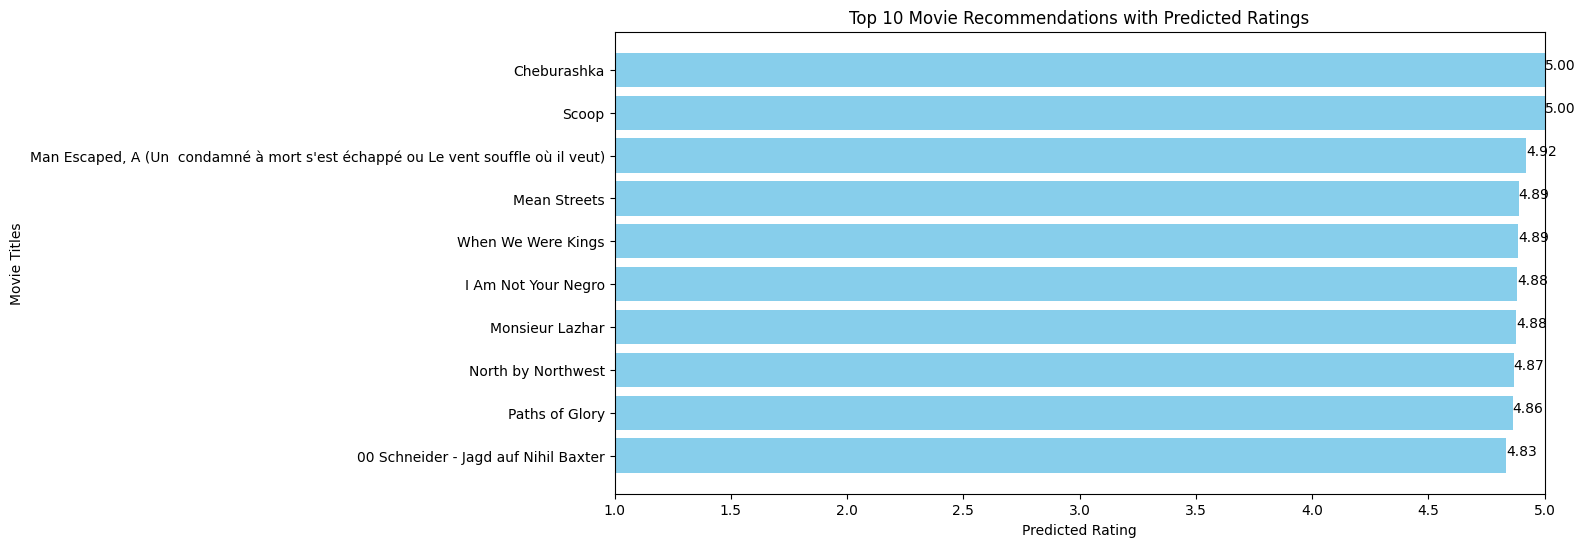

In [ ]:
# Plot the titles and ratings
recommendations_with_ratings = make_recommendations_with_ratings(1, model, merged_df_copy, device, top_n=10, min_rating=1, max_rating=5)
min_rating = 1
max_rating = 5

# Extract movie titles and their corresponding predicted ratings
titles, predicted_ratings = zip(*recommendations_with_ratings)

# Plotting
plt.figure(figsize=(12, 6))
plt.barh(titles, predicted_ratings, color='skyblue')
plt.xlabel('Predicted Rating')
plt.ylabel('Movie Titles')
plt.title('Top 10 Movie Recommendations with Predicted Ratings')
plt.gca().invert_yaxis()
plt.xlim(min_rating, max_rating)
for index, value in enumerate(predicted_ratings):
    plt.text(value, index, f"{value:.2f}")
plt.show()